In [1]:
import os
import sys
import pandas as pd
import numpy as np
import QuantLib as ql
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib import cm

from historical_alphaVantage_collection import chain, start_date


pricing settings:
Actual/365 (Fixed) day counter
New York stock exchange calendar
compounding: continuous
frequency: annual

no data for: Saturday, 2020-01-04
no data for: Sunday, 2020-01-05
no data for: Wednesday, 2020-01-01


In [2]:
def clean_term_structure(date_key,w):
    ivol_df = chain[date_key][w]['surface']
    ivol_df = ivol_df.dropna(how='all',axis=0).dropna(how='all',axis=1)
    strikes = ivol_df.iloc[:,0].dropna().index
    ivol_df = ivol_df.loc[strikes,:].copy()
    T = ivol_df.columns.tolist()
    K = ivol_df.index.tolist()
    ivol_array = ivol_df.to_numpy()
    x = np.arange(0, ivol_array.shape[1])
    y = np.arange(0, ivol_array.shape[0])
    #mask invalid values
    array = np.ma.masked_invalid(ivol_array)
    xx, yy = np.meshgrid(x, y)
    
    x1 = xx[~array.mask]
    y1 = yy[~array.mask]
    newarr = array[~array.mask]
    
    GD1 = interpolate.griddata((x1, y1), newarr.ravel(),
                              (xx, yy),
                                method='cubic')
    vol_surf = pd.DataFrame(
        GD1,
        index = K,
        columns = T
    ).copy()
    
    vol_surf = ivol_df.loc[:,ivol_df.columns>0].dropna(how='any', axis=0).copy()
    return vol_surf

In [3]:
w = 'puts'

In [4]:
surfs = []
for key in chain.keys():
    surfs.append(clean_term_structure(key,w))

In [5]:
for surface in surfs:
    K = surface.index.tolist()
    T = surface.columns.tolist()
    print(T)
    print()
    # print(K)


[1.0, 4.0, 6.0, 8.0, 11.0, 13.0, 15.0, 19.0, 20.0, 22.0, 25.0, 27.0, 29.0, 32.0, 34.0, 36.0, 43.0, 50.0, 78.0, 89.0, 106.0, 134.0, 169.0, 180.0, 260.0, 272.0, 288.0, 323.0, 351.0, 364.0, 379.0, 442.0, 533.0, 624.0, 715.0, 750.0, 1079.0]

[3.0, 5.0, 7.0, 10.0, 12.0, 14.0, 18.0, 19.0, 21.0, 24.0, 26.0, 28.0, 31.0, 33.0, 35.0, 38.0, 42.0, 49.0, 77.0, 88.0, 105.0, 133.0, 168.0, 179.0, 259.0, 271.0, 287.0, 322.0, 350.0, 363.0, 378.0, 441.0, 532.0, 623.0, 714.0, 749.0, 1078.0]

[2.0, 4.0, 7.0, 9.0, 11.0, 15.0, 16.0, 18.0, 21.0, 23.0, 25.0, 28.0, 30.0, 32.0, 35.0, 39.0, 46.0, 74.0, 85.0, 102.0, 130.0, 165.0, 176.0, 256.0, 268.0, 284.0, 319.0, 347.0, 360.0, 375.0, 438.0, 529.0, 620.0, 711.0, 746.0, 1075.0]

[1.0, 3.0, 6.0, 8.0, 10.0, 14.0, 15.0, 17.0, 20.0, 22.0, 24.0, 27.0, 29.0, 31.0, 34.0, 36.0, 38.0, 45.0, 73.0, 84.0, 101.0, 129.0, 164.0, 175.0, 255.0, 267.0, 283.0, 318.0, 346.0, 359.0, 374.0, 437.0, 528.0, 619.0, 710.0, 745.0, 1074.0]

[2.0, 5.0, 7.0, 9.0, 13.0, 14.0, 16.0, 19.0, 21.0, 23

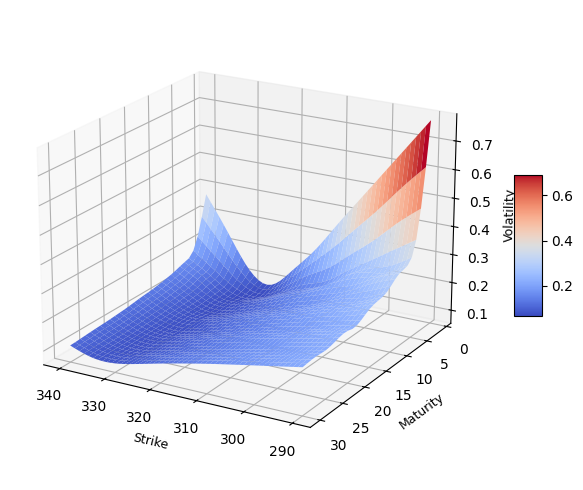

<Figure size 700x500 with 0 Axes>

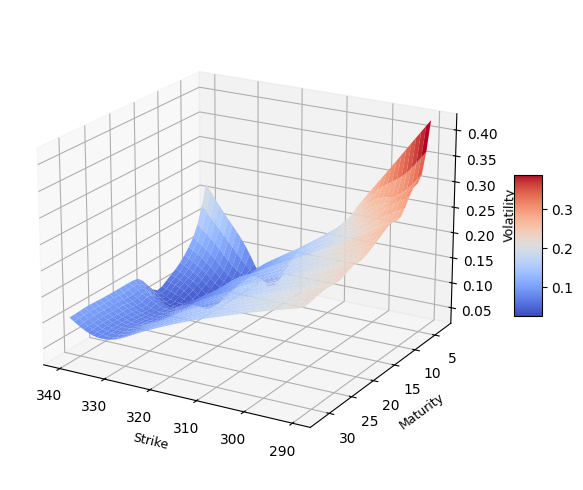

<Figure size 700x500 with 0 Axes>

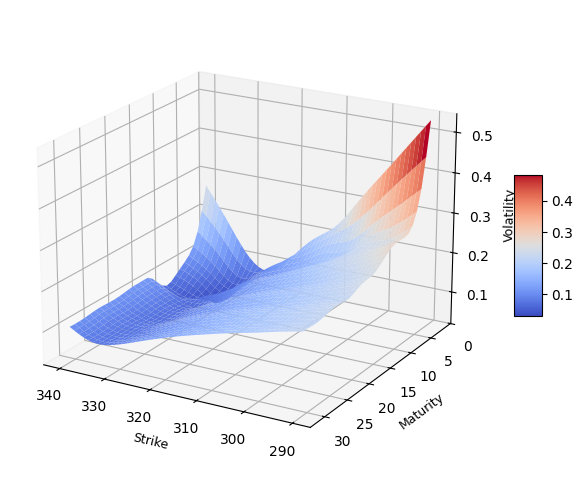

<Figure size 700x500 with 0 Axes>

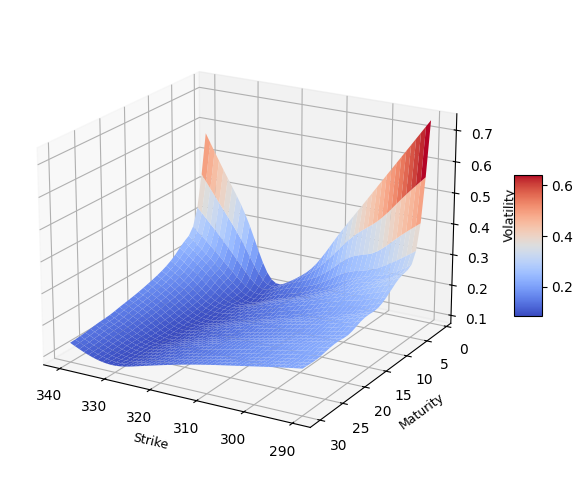

<Figure size 700x500 with 0 Axes>

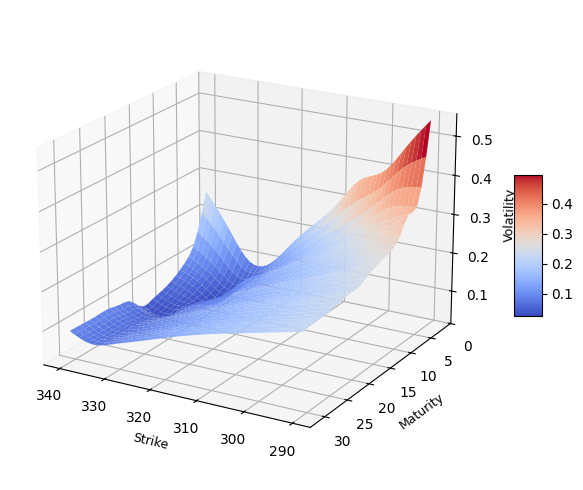

<Figure size 700x500 with 0 Axes>

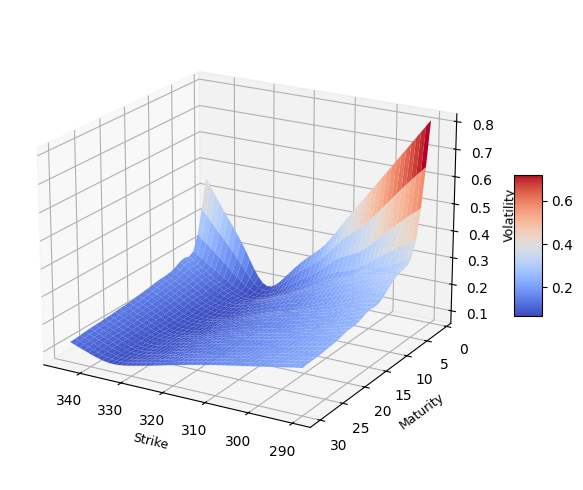

<Figure size 700x500 with 0 Axes>

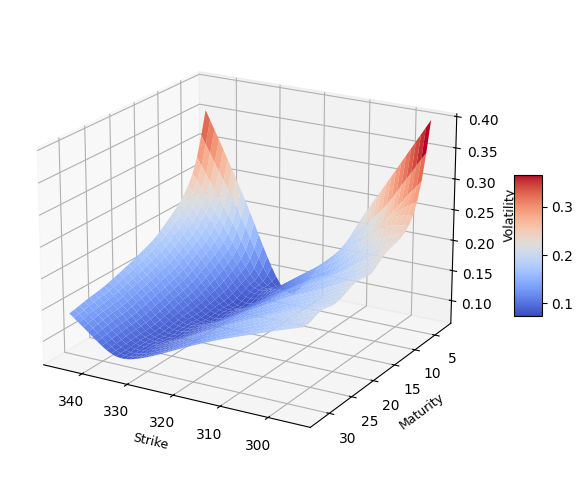

<Figure size 700x500 with 0 Axes>

In [10]:
for surface in surfs:
    T = surface.columns.tolist()
    K = surface.index.tolist()
    vol_matrix = ql.Matrix(len(K),len(T),0.0)
    for i,k in enumerate(K):
        for j,t in enumerate(T):
            vol_matrix[i][j] = float(surface.loc[k,t])
    
    bicubic_vol = ql.BicubicSpline(T,K,vol_matrix)
    
    
    K = np.linspace(
        min(K),
        max(K),
        50
    )
    T = np.arange(
        int(min(T)),
        min(T)+30,
        1
    )
    
    KK,TT = np.meshgrid(K,T)
    
    V = np.array(
        [[bicubic_vol(float(t),float(k),False) for k in K] for t in T]
        )
    
    plt.rcParams['figure.figsize']=(7,5)
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.view_init(elev=20, azim=120)  
    surf = ax.plot_surface(KK,TT,V, rstride=1, cstride=1, cmap=cm.coolwarm,
                    linewidth=0.1)
    fig.colorbar(surf, shrink=0.3, aspect=5)
    
    ax.set_xlabel("Strike", size=9)
    ax.set_ylabel("Maturity", size=9)
    ax.set_zlabel("Volatility", size=9)
    
    plt.tight_layout()
    plt.show()
    plt.cla()
    plt.clf()